<a href="https://colab.research.google.com/github/beatlesatani/coding_september/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#use this website as a refenrece
#https://qiita.com/omiita/items/1735c1d048fe5f611f80
#https://www.youtube.com/watch?v=pXGBHV3y8rs&list=PLeo1K3hjS3uu7CxAacxVndI4bE_o3BDtO&index=12

In [2]:
# the dataset,train.csv and test.csv came from https://www.kaggle.com/datasets/abhi8923shriv/sentiment-analysis-dataset

In [3]:
!pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 15.1 MB/s eta 0:00:00


In [4]:
pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 19.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=b715d915d45ee54cf41b36a11c79703186cb291b68e24df8cdcf69fa7951ece9
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [5]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [6]:
#setup the dataset
test = 'https://raw.githubusercontent.com/beatlesatani/coding_september/main/test.csv'
train = "https://raw.githubusercontent.com/beatlesatani/coding_september/main/train.csv"
test = pd.read_csv(test,encoding='unicode_escape')
train = pd.read_csv(train,encoding='unicode_escape')

In [7]:
# remove unusuful columns
test = test.iloc[:,1:3]
train = train.iloc[:, [1,3]]

In [8]:
#check the insull values of train dataframe
train.isnull().sum()
#only one text is missing, so drop that low that incluse null cell
train = train.dropna()
#re-check null values
train.isnull().sum()

text         0
sentiment    0
dtype: int64

In [9]:
#check the insull values of train dataframe
test.isnull().sum()

text         1281
sentiment    1281
dtype: int64

In [10]:
#afeter checking original csv file, all raws after 3533 is null
test = test.dropna()
#re-check null values
test.isnull().sum()

text         0
sentiment    0
dtype: int64

In [11]:
#check the label imbalance
train['sentiment'].value_counts(normalize=True)


neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

In [12]:
test['sentiment'].value_counts(normalize=True)

neutral     0.404641
positive    0.312111
negative    0.283248
Name: sentiment, dtype: float64

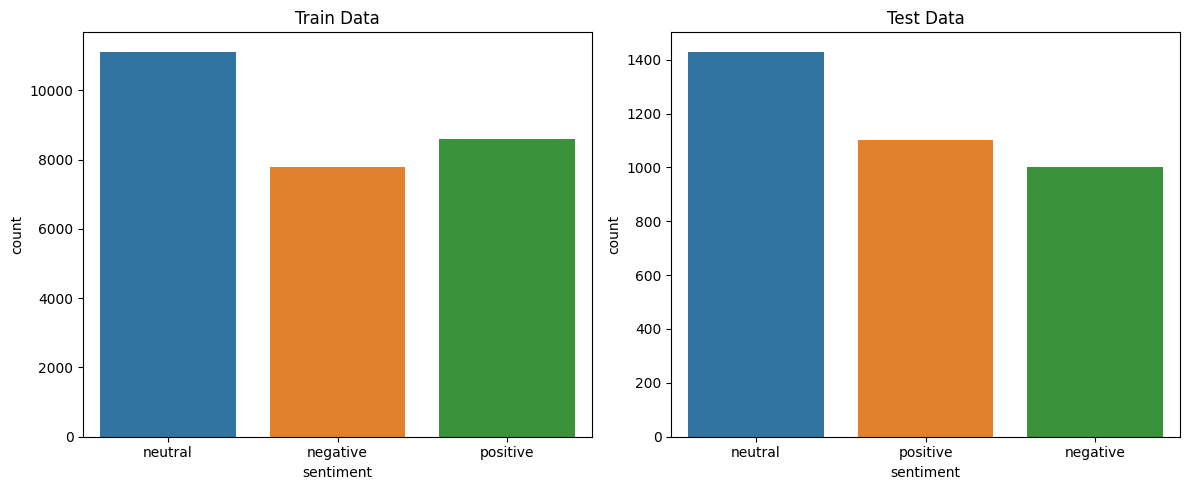

In [13]:
#graph
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='sentiment', data=train, ax=axes[0],saturation = 0.75)
axes[0].set_title('Train Data')

# Plot the countplot for 'sentiment' in the 'test' DataFrame
sns.countplot(x='sentiment', data=test, ax=axes[1])
axes[1].set_title('Test Data')

# Adjust layout for better visibility
plt.tight_layout()

# Show the plots
plt.show()


## we can conclude the labels are not inbalanced

## convert each sentiment into numerical value
### neagtive → -1
### neutral → 0
### postive → 1

In [14]:
#before working to the model, convert labels into numerical number
train['label'] = train['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
train = train.drop('sentiment',axis = 1)
test['label'] = test['sentiment'].apply(lambda x: -1 if x== 'negative' else(0 if x == 'neutral' else 1))
test = test.drop('sentiment',axis = 1)

In [15]:
train['label'].value_counts(normalize=True) # got same ratio before converting

 0    0.404549
 1    0.312300
-1    0.283151
Name: label, dtype: float64

In [16]:
train

,text,label
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,-1
2,my boss is bullying me...,-1
3,what interview! leave me alone,-1
4,"Sons of ****, why couldn`t they put them on t...",-1
...,...,...
27476,wish we could come see u on Denver husband l...,-1
27477,I`ve wondered about rake to. The client has ...,-1
27478,Yay good for both of you. Enjoy the break - y...,1
27479,But it was worth it ****.,1


In [17]:
#split the dataset
X_train = train['text']
y_train = train['label']
X_test = test['text']
y_test = test['label']

## data preprocessing part


> Here, I use BERT not word2vec for fine-tuning cause BERT can cosider context.



> Whole Process of the Model


1.   text is imported in the InputLayer
2.   In the BERT layer, texts are converted into the vector so that model can retrieve it
3.  In the neural network layer, some parameter tuning is done






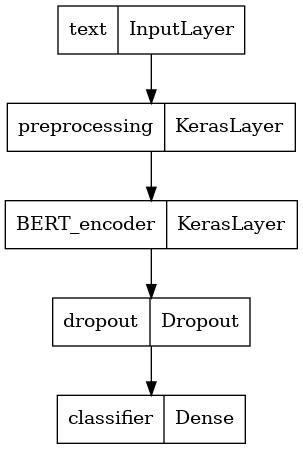



In [18]:
bert_preprocess= hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder =  hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [19]:

#binary classification ではないから注意
def build_classifier_model():
  # Bert layers
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessed_text = bert_preprocess(text_input)
  outputs = bert_encoder(preprocessed_text)  #here converted into the vector

  # Neural network layers
  l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
  l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

  # Use inputs and outputs to construct a final model
  model = tf.keras.Model(inputs=[text_input], outputs = [l])
  return model

In [20]:
classifier_model = build_classifier_model()

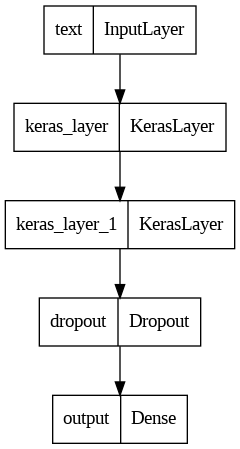

In [21]:
tf.keras.utils.plot_model(classifier_model)

In [22]:
#ここらへんのチューニング　さらに勉強する必要あり

In [28]:
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

classifier_model.compile(optimizer='adam',
              loss='SparseCategoricalCrossentropy',
              metrics=METRICS)

In [29]:
classifier_model.fit(X_train,y_train,epochs = 5)

Epoch 1/5
450/859 [==============>...............] - ETA: 2:19 - loss: nan - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00

KeyboardInterrupt: ignored

In [ ]:
#more parameter tuting section to improve accuracy